In [1]:
%load_ext autoreload

In [66]:
%autoreload 2
import sklearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import fnmatch
import os
import sklearn
import pymc3 as pm
import seaborn
from theano import shared


In [3]:
from curve import predict

In [ ]:
data_dir = "/home/dorran/Documents/hackathon/New_Marmousi_Data/all_synth_data"
curves = predict.read_all_synthetic_curves(data_dir, "-999.00000000")

In [ ]:
for well, df in curves.items():
    df["well"] = well

In [ ]:
curve_df = pd.concat([x for x in curves.values()])

In [4]:
curve_df = pd.read_csv('all_synthetic_well_logs.csv')

In [5]:
curve_df = curve_df.dropna()

In [6]:
wells = curve_df.well.unique()

In [7]:
from sklearn.model_selection import train_test_split

train_wells, test_wells = train_test_split(wells, test_size=0.2)

In [8]:
# Get training curves and shuffle
train_curves = curve_df[curve_df.well.isin(train_wells)].sample(frac=1).reset_index(drop=True)

In [9]:
test_curves = curve_df[curve_df.well.isin(test_wells)].sample(frac=1).reset_index(drop=True)

In [ ]:
test_curves

In [ ]:
plt.matshow(curve_df.corr())
plt.show()

In [ ]:
curve_df.corr()

In [98]:
train_subset = train_curves.sample(100)


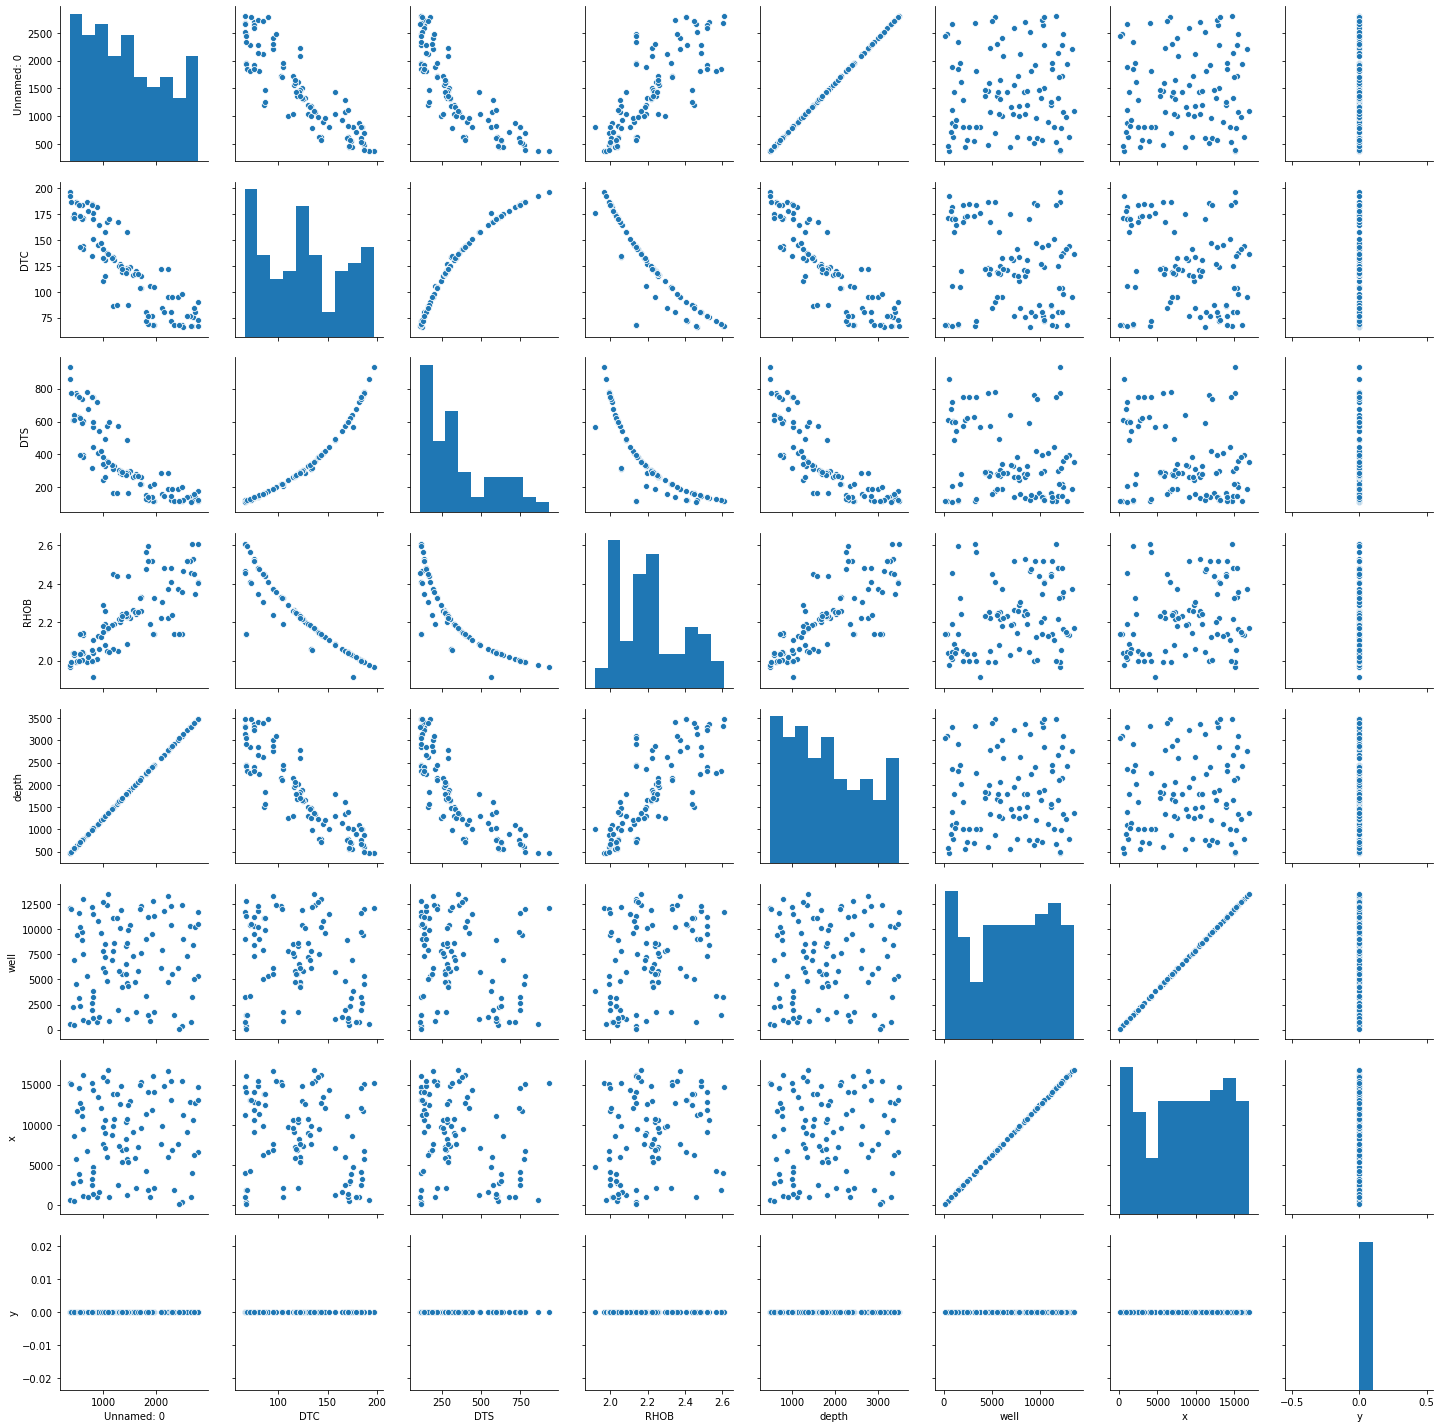

In [99]:
seaborn.pairplot(train_subset)

In [15]:
train_subset

,Unnamed: 0,DTC,DTS,RHOB,depth,well,x,y
21360387,1354,159.822690,506.747964,2.076768,1692.50,1195,1492.50,0.0
15941291,522,185.050830,759.562376,1.997653,652.50,3898,4871.25,0.0
25805867,2162,87.134478,155.793950,2.301734,2702.50,40,48.75,0.0
23179378,2291,87.086242,166.014079,2.289000,2863.75,7439,9297.50,0.0
18328990,2573,87.086242,166.740617,2.429999,3216.25,5488,6858.75,0.0
...,...,...,...,...,...,...,...,...
2629692,737,149.000913,430.425593,2.115715,921.25,13287,16607.50,0.0
20351220,720,140.883683,381.529405,2.147356,900.00,9042,11301.25,0.0
11057397,2683,65.268062,111.689941,2.622999,3353.75,11292,14113.75,0.0
7590887,1227,163.219304,533.872067,2.065227,1533.75,3068,3833.75,0.0


In [54]:
# Need to add noise to vp ~ vs relation
train_subset.loc[:, "DTC"] = train_subset.DTC + np.random.rand(train_subset.shape[0])*50

In [162]:
train_subset = train_curves.sample(10000)
train_subset.head()

,Unnamed: 0,DTC,DTS,RHOB,depth,well,x,y
25755175,1504,119.483280,277.782051,2.243189,1880.00,5669,7085.00,0.0
5171981,790,179.202968,688.547633,2.014725,987.50,5147,6432.50,0.0
24253281,2411,67.733744,117.231480,2.139999,3013.75,754,941.25,0.0
16552781,1089,136.085543,355.399612,2.167166,1361.25,13305,16630.00,0.0
23439027,2664,80.211013,148.033923,2.483000,3330.00,13334,16666.25,0.0


In [167]:
def norm_df(df, mean=None, delta=None):
    if mean is None:
        mean = df.mean()
    if delta is None:
        delta = df.max() - df.min()
    normed = (df - mean) / delta
    return mean, delta, normed

def restore_normed_df(norm_df, mean, delta):
    return (norm_df * delta) + mean 


In [163]:
norm_mean, norm_delta, normed_train_subset = norm_df(train_subset)
normed_train_subset.head()

,Unnamed: 0,DTC,DTS,RHOB,depth,well,x,y
25755175,-0.034391,0.001396,-0.049500,0.009842,-0.034391,-0.081462,-0.081462,NaN
5171981,-0.327134,0.259199,0.384213,-0.210470,-0.327134,-0.119848,-0.119848,NaN
24253281,0.337483,-0.222001,-0.219020,-0.089666,0.337483,-0.442886,-0.442886,NaN
16552781,-0.204543,0.073066,0.032453,-0.063469,-0.204543,0.480050,0.480050,NaN
23439027,0.441214,-0.168138,-0.186497,0.241096,0.441214,0.482182,0.482182,NaN


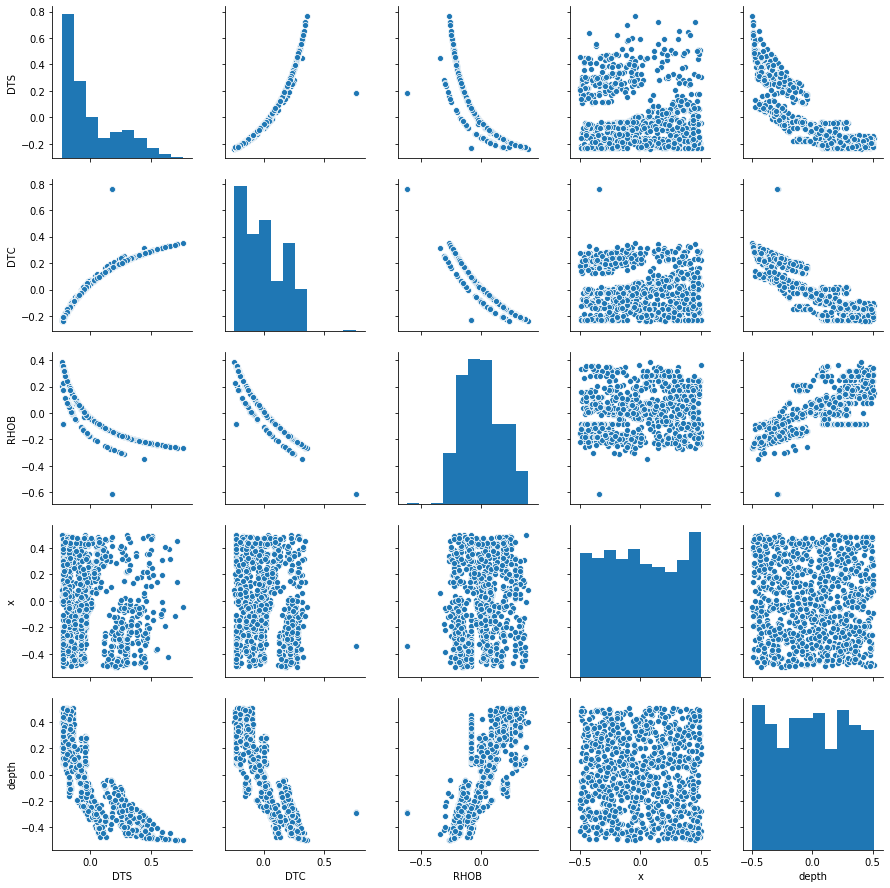

In [158]:
seaborn.pairplot(normed_train_subset[["DTS", "DTC", "RHOB", "x", "depth"]])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_depth, b_dtc, b_rho, alpha, sigma_mod]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:16<00:00, 373.51draws/s]
The acceptance probability does not match the target. It is 0.9425567544491235, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9053543887932106, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8851115705215398, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8889828126267223, but should be close to 0.8. Try to increase the number of tuning steps.


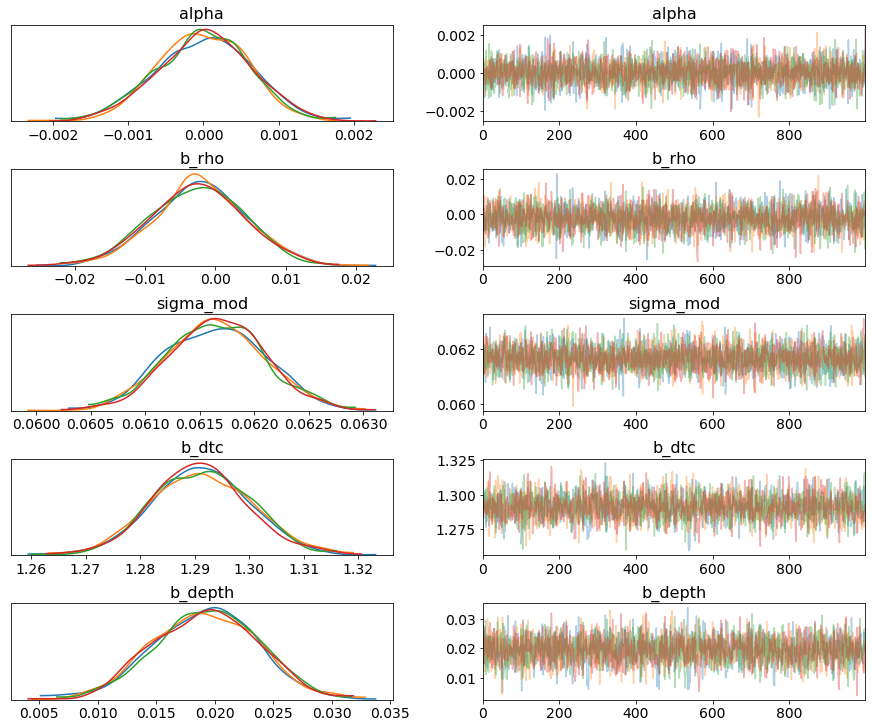

In [194]:
shared_dtc = shared(normed_train_subset.DTC.values)
shared_rhob = shared(normed_train_subset.RHOB.values)
shared_x = shared(normed_train_subset.x.values)
shared_y = shared(normed_train_subset.y.values)
shared_depth = shared(normed_train_subset.depth.values)
shared_dts = shared(normed_train_subset.DTS.values)

with pm.Model() as linear_model:
    # Priors
    sigma_mod = pm.HalfNormal('sigma_mod', 2)
    alpha = pm.Normal('alpha', sigma=1)
    b_rho = pm.Normal('b_rho', sigma=1)
    b_dtc = pm.Lognormal('b_dtc', mu=0, sigma=1)
    # b_x = pm.Normal('b_x', mu=x_mu, sigma=x_sd)
    # b_y = ...
    b_depth = pm.HalfFlat('b_depth')
      
    # Transform parameters into a prediction
    dts_pred = alpha + \
           b_dtc * shared_dtc + \
           b_rho * shared_rhob + \
           b_depth * shared_depth
    
    # Likelihood function
    dts_obs = Normal(
        'dts_obs', 
        mu=dts_pred, 
        sigma=sigma_mod,
        observed=shared_dts)
    
    trace = pm.sample(1000 , cores=4)
    
    pm.plots.traceplot(trace)
    
    # priorpc = pm.sample_prior_predictive()

In [160]:
pm.diagnostics.gelman_rubin(trace)

{'alpha': 0.9997549004777841,
 'b_rho': 1.0005427172280377,
 'sigma_mod': 0.9995581634223203,
 'b_dtc': 1.0006652240145757,
 'b_depth': 1.0000349945319824}

## Make Posterior Predictions for Test Dataset

In [196]:
# Feed test values into model and get predictions
ex_wells = test_wells[0:3]
ex_curves = test_curves[test_curves.well.isin(ex_wells)]
ex_curves.head()

,Unnamed: 0,DTC,DTS,RHOB,depth,well,x,y
983,2250,121.920739,288.092484,2.221999,2812.50,696,868.75,0.0
2336,469,146.832751,416.737751,2.123949,586.25,7687,9607.50,0.0
4292,871,181.842335,719.441887,2.006934,1088.75,696,868.75,0.0
5083,2114,84.667180,159.665714,2.304999,2642.50,7687,9607.50,0.0
5189,1858,95.250578,188.615005,2.237000,2322.50,7687,9607.50,0.0


In [197]:
_m, _d, normed_test  = norm_df(ex_curves, mean=norm_mean, delta=norm_delta)

# Update data variables with test data
shared_dtc.set_value(normed_test.DTC.values)
shared_rhob.set_value(normed_test.RHOB.values)
shared_x.set_value(normed_test.x.values)
shared_y.set_value(normed_test.y.values)
shared_depth.set_value(normed_test.depth.values)

# Produce posterior predictions
ppc = pm.sample_posterior_predictive(trace, model=linear_model)
dts_pred = ppc["dts_obs"]


100%|██████████| 4000/4000 [00:46<00:00, 86.29it/s]


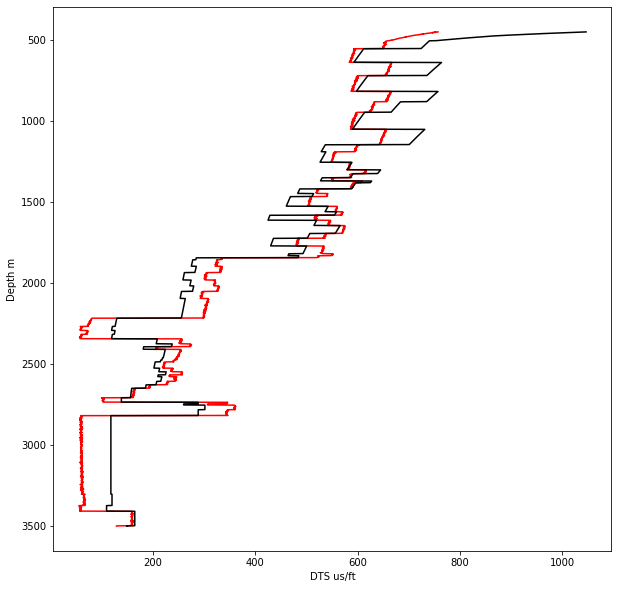

In [206]:
# Extract percentiles for predictions
unnormed_pred = restore_normed_df(dts_pred, mean=norm_mean.DTS, delta=norm_delta.DTS)
percentiles = np.percentile(unnormed_pred, [10, 50, 90], axis=0)
ex_curves.loc[:,"PRED_DTS_10"] = percentiles[0,:]
ex_curves.loc[:,"PRED_DTS_50"] = percentiles[1,:]
ex_curves.loc[:,"PRED_DTS_90"] = percentiles[2,:]

ex_curves.head()

example_well_1 = ex_wells[0]
pred_well_1 = ex_curves[ex_curves.well == example_well_1]
pred_well_1 = pred_well_1.sort_values('depth')
plt.figure(figsize=(10,10))
plt.plot(pred_well_1.PRED_DTS_50, pred_well_1.depth, color='red')
# plt.plot(pred_well_1.PRED_DTS_10, pred_well_1.depth, color='blue')
#plt.plot(pred_well_1.PRED_DTS_90, pred_well_1.depth, color='blue')
plt.plot(pred_well_1.DTS, pred_well_1.depth, color='black')
plt.gca().invert_yaxis()
plt.xlabel("DTS us/ft")
plt.ylabel("Depth m")
plt.show()

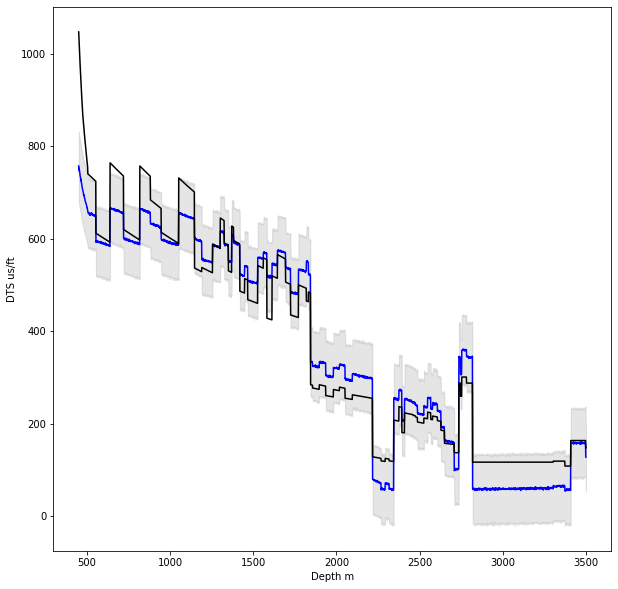

<function matplotlib.pyplot.fill_betweenx(y, x1, x2=0, where=None, step=None, interpolate=False, *, data=None, **kwargs)>

In [248]:

plt.figure(figsize=(10,10))
plt.plot(pred_well_1.depth, pred_well_1.PRED_DTS_50, color='blue')
# plt.plot(pred_well_1.PRED_DTS_10, pred_well_1.depth, color='blue')
#plt.plot(pred_well_1.PRED_DTS_90, pred_well_1.depth, color='blue')
plt.plot(pred_well_1.depth, pred_well_1.DTS, color='black')

plt.fill_between(pred_well_1.depth, pred_well_1.PRED_DTS_10, pred_well_1.PRED_DTS_90,
                 color='gray', alpha=0.2)

plt.ylabel("DTS us/ft")
plt.xlabel("Depth m")
plt.show()

plt.fill_betweenx

In [239]:
ex_curves = ex_curves.sort_values('depth')
draws_well_1 = dts_pred[:,ex_curves[ex_curves['well'] == example_well_1].index.tolist()]
depths_well_1 = ex_curves[ex_curves['well'] == example_well_1].depth

In [242]:
all_x = np.hstack([draws_well_1[0,:] , draws_well_1[1,:] ,draws_well_1[2,:] ,draws_well_1[3,:]])
all_y = np.hstack([depths_well_1.values, depths_well_1.values, depths_well_1.values, depths_well_1.values])
well_1_df = pd.DataFrame({'x': all_x, 'y': all_y})
print(all_x.shape)
print(all_y.shape)

(9760,)
(9760,)


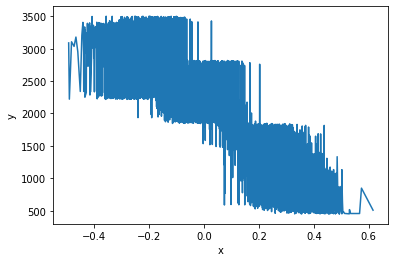

In [243]:
seaborn.lineplot(
    x ='x' ,
    y ='y',
    data = well_1_df)